# Demo: Q&A on Documentation

## Markdown from intellij-community

In [294]:
ij_doc_embeddings='ij-community-markdown_ddca03838_mdchunk_embeddings.pkl.gz'

import os
if not os.path.exists(ij_doc_embeddings):
    !wget "https://storage.googleapis.com/semantic-cs/$ij_doc_embeddings"

import pandas as pd
df_ij_doc = pd.read_pickle(ij_doc_embeddings)


In [296]:
import os
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

# run 'Context Engineering (precise)' scection first
answer_question(df_ij_doc, question="How do I build IntelliJ Idea?", max_len=1000, debug=False)

'To build IntelliJ IDEA Community Edition from source, choose **Build | Build Project** from the main menu. To build installation packages, run the `installers.cmd` command in `<IDEA_HOME>` directory. `installers.cmd` will work on both Windows and Unix systems.'

## Markdown from intellij-sdk-doc

In [292]:
sdk_doc_embeddings='ij-sdk-docs-markdown_c2a526bcc_mdchunk_embeddings.pkl.gz'

import os
if not os.path.exists(sdk_doc_embeddings):
    !wget "https://storage.googleapis.com/semantic-cs/$sdk_doc_embeddings"

import pandas as pd
df_sdk = pd.read_pickle(sdk_doc_embeddings)


In [291]:
import os
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

# run 'Context Engineering (precise)' scection first
answer_question(df_sdk, question="How to create a custom syntax highlighter?", max_len=1000, debug=False)

'The syntax highlighter is created by extending the `SyntaxHighlighter` interface and registering the factory with the IntelliJ Platform in the plugin configuration file using the `com.intellij.lang.syntaxHighlighterFactory` extension point.'

## KDoc and JavaDoc from intellij-community

In [ ]:
#TBD

## Retrival

In [5]:
code_root = "../intellij-community" # change to your local path
model="text-embedding-ada-002"

#!git clone --depth=1 'https://github.com/JetBrains/intellij-community/' "$code_root"

In [ ]:
#!find $code_root -name "*.md" | grep -v -E '/test(s)?(Src)?(ing)?(Data)?/' | wc -l
#  79
# does NOT work on the notebook, after the 2nd pipe the results EXPLODE :/
# find ../intellij-community -name "*.md" | grep -v -E '/test(s)?(Src)?(ing)?(Data)?/' | xargs -I{} wc -m {} | awk '{i+=$1;} END {print i;}'
#  245371
# that is only 500 chunks by 500 chars

### TODOs
 * extract parsers.py, re-use here and in code_search
   * get functions: parse all community, save to .pkl
   * get documentation: class/method K/JavaDocs

In [ ]:
#git rev-parse --short HEAD
#!find . -name "*.md" -printf '%P\n' | grep -v -E '/test(s)?(Src)?(ing)?(Data)?/' > ij-community-markdown_$sha.csv

In [27]:
import os
import pandas as pd


with open(f"{code_root}/.git/refs/heads/master") as f:
    sha = f.read()[:9]

basename=f"ij-community-markdown_{sha}"
markdown_files = f"{basename}.csv"

In [85]:
from pathlib import Path

md = pd.read_csv(markdown_files, names=["file"])
md['text'] = md['file'].apply(lambda f: (code_root / Path(f)).read_text())

In [9]:
md

,file,text
0,CODE_OF_CONDUCT.md,## Code of Conduct\n\nThis project and the cor...
1,native/WinShellIntegration/README.md,# WinShellIntegration\nThe library provides th...
2,native/WinShellIntegration/src/winshellintegra...,# winshellintegration\nStatic library provides...
3,native/WinShellIntegration/src/winshellintegra...,# winshellintegrationbridge\nJNI-Dll integrate...
4,native/repair-utility/README.md,Repair is the command line utility to troubles...
...,...,...
74,docs/configurable.md,## Configurables allow adding settings to the ...
75,README.md,# IntelliJ IDEA Community Edition [![official ...
76,CONTRIBUTING.md,Contributing to IntelliJ IDEA\n===\n\nBefore o...
77,build/tools/NSIS-upgrade.md,### Upgrading NSIS to a newer version\n\nThe N...


In [86]:
import tiktoken

tokenizer = encoding = tiktoken.encoding_for_model(model) #tiktoken.get_encoding("cl100k_base")

md['n_tokens'] = md['text'].apply(lambda x: len(tokenizer.encode(x)))

In [87]:
md['n_tokens'].describe()

count      79.000000
mean      715.607595
std      1063.225407
min        17.000000
25%        99.500000
50%       297.000000
75%       843.500000
max      6101.000000
Name: n_tokens, dtype: float64

## Chunking

Breaking up longer text in smaller chunks seems to be an important "hyperparameter" i.e. we should experiment with different options.

<Axes: >

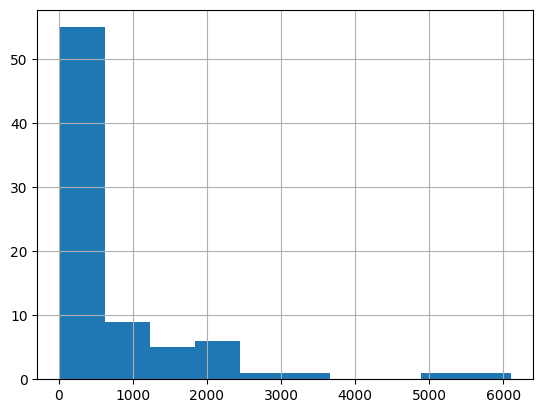

In [88]:
md['n_tokens'].hist()

In [222]:
print(f"No chunks:{len(md)}, Tokens:{md['n_tokens'].sum()}")

No chunks:79, Tokens:56533


### Naive

In [13]:
# A naive way of context-aware chunking relying on sentence segmentation by "." 
# 
# There is some evidence that model like text-embedding-ada-002
# performs better on chunks containing 256 or 512 tokens.
# See https://www.pinecone.io/learn/chunking-strategies/

from typing import List

max_tokens = 500

# Split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens) -> List[str]:
    sentences = text.split('. ')

    # number of tokens per sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunk = []
    chunks = []
    tokens_so_far = 0

    for sentence, token in zip(sentences, n_tokens):
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        if token > max_tokens:
            continue

        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks

In [90]:
chunks = []

for i, row in md.iterrows():
    if row['n_tokens'] > max_tokens:
        chunks += split_into_many(row['text'])
    else:
        chunks.append(row['text'] )

<Axes: >

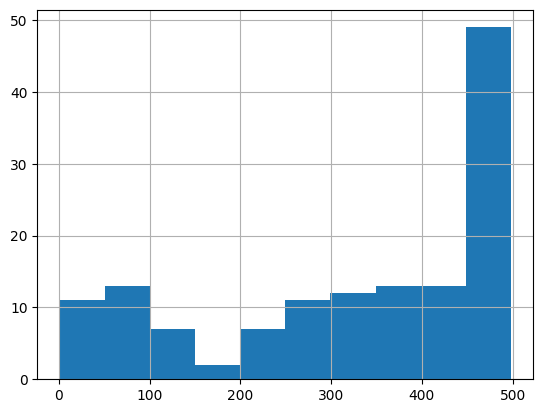

In [91]:
df = pd.DataFrame(chunks, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [224]:
print(f"Naive chunks:{len(df)}, Tokens:{df['n_tokens'].sum()}")
# total tokens: 56533

Naive chunks:138, Tokens:44540


In [23]:
df

,text,n_tokens
0,## Code of Conduct\n\nThis project and the cor...,62
1,# WinShellIntegration\nThe library provides th...,399
2,# winshellintegration\nStatic library provides...,49
3,# winshellintegrationbridge\nJNI-Dll integrate...,97
4,Repair is the command line utility to troubles...,352
...,...,...
133,\n\n## Building IntelliJ Community Edition\nVe...,386
134,`installers.cmd` will work on both Windows and...,366
135,Contributing to IntelliJ IDEA\n===\n\nBefore o...,95
136,### Upgrading NSIS to a newer version\n\nThe N...,459


### Advanced

Markdown header-aware [RecursiveCharacterTextSplitter](https://python.langchain.com/en/latest/_modules/langchain/text_splitter.html)

In [ ]:
%pip install langchain

In [105]:
from langchain.text_splitter import MarkdownTextSplitter
markdown_splitter = MarkdownTextSplitter(chunk_size=500, chunk_overlap=0)

In [211]:
df_md = md.copy()

79


In [258]:
df_md['text'] = df_md.text.apply(lambda text: markdown_splitter.split_text(text))
df_md = df_md.explode("text")
df_md.head()

,file,text,n_tokens,chunk,embeddings,distances
0,CODE_OF_CONDUCT.md,## Code of Conduct\n\nThis project and the cor...,61,## Code of Conduct\n\nThis project and the cor...,"[-0.00040333083597943187, -0.00013125549594406...",0.262480
1,native/WinShellIntegration/README.md,# WinShellIntegration\nThe library provides th...,99,# WinShellIntegration\nThe library provides th...,"[-0.02148049883544445, 0.0078047215938568115, ...",0.270736
1,native/WinShellIntegration/README.md,Build dependencies\n* C++17-compatible compile...,99,# WinShellIntegration\nThe library provides th...,"[-0.02148049883544445, 0.0078047215938568115, ...",0.270736
1,native/WinShellIntegration/README.md,Build\nJust use CMake normally.,99,# WinShellIntegration\nThe library provides th...,"[-0.02148049883544445, 0.0078047215938568115, ...",0.270736
1,native/WinShellIntegration/README.md,If you want to build [winshellintegrationbridg...,99,# WinShellIntegration\nThe library provides th...,"[-0.02148049883544445, 0.0078047215938568115, ...",0.270736


In [213]:
# df_md['chunks'].apply(len).sum()
print(len(df_md))

781


In [247]:
df_md['n_tokens'] = df_md['chunk'].apply(lambda x: len(tokenizer.encode(x)))

<Axes: >

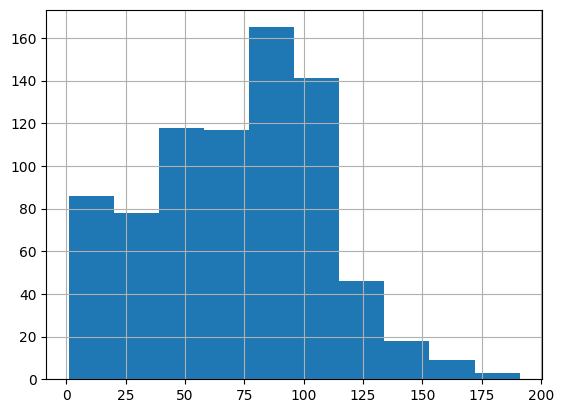

In [248]:
df_md['n_tokens'].hist()

In [223]:
print(f"Advanced chunks:{len(df_md)}, Tokens:{df_md['n_tokens_chunk'].sum()}")
# total tokens: 56533

Advanced chunks:781, Tokens:55934


## Fetch Embeddings

In [31]:
import os

import openai
import numpy as np

openai.api_key = os.getenv("OPENAI_API_KEY")

df['embeddings'] = df.text.apply(lambda x: np.array(openai.Embedding.create(input=x, engine=model)['data'][0]['embedding']))
df.to_pickle(f"{basename}_embeddings.pkl") # ~100 requests

In [227]:
df_md['embeddings'] = df_md.chunk.apply(lambda x: np.array(openai.Embedding.create(input=x, engine=model)['data'][0]['embedding']))
# ~700 requests

In [266]:
df_md.to_pickle(f"{basename}_mdchunk_embeddings.pkl.gz", compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

## Context Engineering: (precise) Q&A

Stores all the documents (chunks) in RAM and sort them by all similarity on every query.

In [48]:
from openai.embeddings_utils import distances_from_embeddings

def create_context(question, df, max_len=1800):
    """
    Create a context for a question by finding the most similar context from the dataframe
    Depends on the 'text', 'n_tokens' and 'embeddings' fields in the dataframe!
    """

    # Get the embeddings for the question
    q_embeddings = np.array(openai.Embedding.create(input=question, engine=model)['data'][0]['embedding'])

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')

    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [34]:
answer_question(df, question="How do I build IntelliJ Idea?", debug=True)

'To build IntelliJ IDEA Community Edition from source, choose **Build | Build Project** from the main menu. To build installation packages, run the `installers.cmd` command in `<IDEA_HOME>` directory.'

In [41]:
answer_question(df, question="How can I build IntelliJ Idea from sources?", max_len=3000, debug=False)

'Version 2022.1 or newer of IntelliJ IDEA Community Edition or IntelliJ IDEA Ultimate Edition is required to build and develop for the IntelliJ Platform. Using IntelliJ IDEA **File | Open**, select the `<IDEA_HOME>` directory. Make sure you have at least 8GB of RAM on your computer. To build IntelliJ IDEA Community Edition from source, choose **Build | Build Project** from the main menu. To build installation packages, run the `installers.cmd` command in `<IDEA_HOME>` directory.'

In [37]:
answer_question(df, question="What is an IDE feature trainer?", debug=False)

'An IDE feature trainer is a plugin for IntelliJ IDEA that helps users learn the basic editing features of the IDE.'

In [ ]:
answer_question(df_md, question="How to create a custom syntax highlighter?", max_len=1000, debug=False)

## Context Engineering: (index) Q&A

Store all the documents (chunks) in RAM, but use approximate nearest neirbor index from HDD on every query.

In [ ]:
# TODO: use FAISS this time

# Retrive & Embed SDK docs

IntelliJ SDK docs have x10 more data in Markdown

In [ ]:
doc_root="../intellij-sdk-docs" # change to your local path
#!git clone --depth=1 'git@github.com:JetBrains/intellij-sdk-docs.git' "$doc_root"

In [ ]:
# find -name "*.md"  -printf '%P\n' | grep -v -E '/test(s)?(Src)?(ing)?(Data)?/' | wc -l
#  317
# find -name "*.md" | grep -v -E '/test(s)?(Src)?(ing)?(Data)?/' | xargs -I{} wc -m {} | awk '{i+=$1;} END {print i;}'
#  2504986

In [93]:
sha = Path(f"{doc_root}/.git/refs/heads/main").read_text()[:9]

sdk_basename=f"ij-sdk-docs-markdown_{sha}"
sdk_files = f"{sdk_basename}.csv"

In [98]:
mdd = pd.read_csv(sdk_files, names=["file"])
mdd['text'] = mdd['file'].apply(lambda f: (doc_root / Path(f)).read_text())
mdd['n_tokens'] = mdd['text'].apply(lambda x: len(tokenizer.encode(x)))

print(f"Docs:{len(mdd)}, Tokens:{mdd['n_tokens'].sum()}")

Docs:317, Tokens:567825


In [231]:
mdd['n_tokens'].describe()

count       317.000000
mean       1791.246057
std        6614.913153
min          34.000000
25%         462.000000
50%         949.000000
75%        1894.000000
max      113224.000000
Name: n_tokens, dtype: float64

<Axes: >

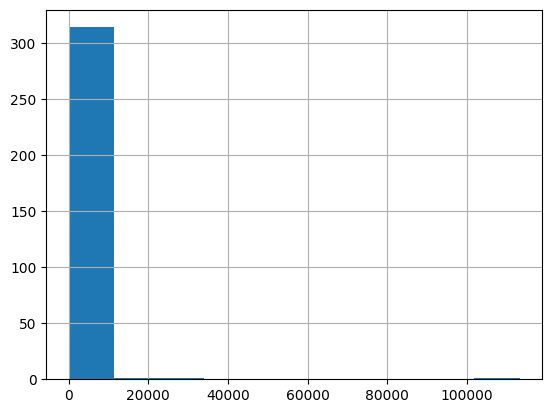

In [232]:
mdd['n_tokens'].hist()

In [240]:
print(f"No chunks:{len(mdd)}, Tokens:{mdd['n_tokens'].sum()}")

No chunks:317, Tokens:567825


In [281]:
del df_sdk

In [282]:
df_sdk = mdd.copy()

df_sdk['text'] = df_sdk.text.apply(lambda text: markdown_splitter.split_text(text))
df_sdk = df_sdk.explode("text")

#df_sdk['n_tokens'] = df_sdk['text'].apply(lambda x: len(tokenizer.encode(x)))
df_sdk['tokens'] = df_sdk['text'].apply(lambda x: tokenizer.encode(x))
df_sdk['n_tokens'] = df_sdk['tokens'].apply(len)

<Axes: >

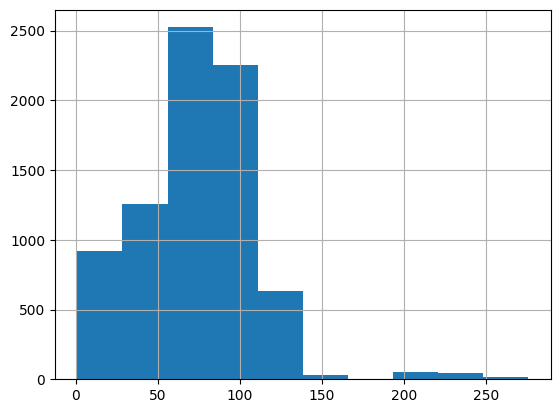

In [284]:
df_sdk.n_tokens.hist()

In [285]:
print(f"Markdown chunks:{len(df_sdk)}, Tokens:{df_sdk['n_tokens'].sum()}")

Markdown chunks:7729, Tokens:564055


In [286]:
print(f"Price: ${(df_sdk['n_tokens'].sum() / 1000) * 0.0004:.2f}")
print(f"Min time: {((df_sdk['n_tokens'].sum() / 2048) / 3500):.2f} min")
# ~7k documents total, batch by 2k each

# limit
#  3,500 RPM / 350,000 TPM

Price: $0.23
Min time: 0.08 min


In [269]:
from embeddings import get_embeddings

In [287]:
df_sdk['embeddings'] = df_sdk.groupby(np.arange(len(df_sdk))//2048)['tokens'].transform(lambda x: get_embeddings(x.tolist(), engine=model))

In [288]:
df_sdk.to_pickle(f"{sdk_basename}_mdchunk_embeddings.pkl.gz", compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})